In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep
hep.style.use("CMS")
import glob, re, sys

from functions import loadMultiParquet, cut, getXSectionBR, sortPredictions, getDfProcesses
sys.path.append("/t3home/gcelotto/ggHbb/PNN")
from helpers.preprocessMultiClass import preprocessMultiClass
from applyMultiClass_Hpeak import getPredictions, splitPtFunc
sys.path.append("/t3home/gcelotto/ggHbb/scripts/plotScripts")
from plotFeatures import plotNormalizedFeatures

In [89]:
nReal = 300
nMC = -1
predictionsPath = "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/PNNpredictions_nov18"
isMCList = [0, 1,
            2,
            3, 4, 5,
            6,7,8,9,10,11,
            12,13,14,
            15,16,17,18,19,
            20, 21, 22, 23, 36,
            #39    # Data2A
]

# Take the DataFrame with processes, path, xsection. Filter the needed rows (processes)
dfProcesses = getDfProcesses()
processes = dfProcesses.process[isMCList].values

# Put all predictions used for training in the proper folder. They will not be used here
sortPredictions()

# Get predictions names path for all the datasets
predictionsFileNames = []
for p in processes:
    print(p)
    tempFileNames = glob.glob(predictionsPath+"/%s/others/*.parquet"%p)
    sortedFileNames = sorted(tempFileNames, key=lambda x: int(''.join(filter(str.isdigit, x))))
    predictionsFileNames.append(sortedFileNames)
    if len(predictionsFileNames)==0:
        print("*"*10)
        print("No Files found for process ", p)
        print("*"*10)

# For each fileNumber extract the fileNumber
predictionsFileNumbers = []
for isMC, p in zip(isMCList, processes):
    idx = isMCList.index(isMC)
    print("Process %s # %d"%(p, isMC))
    l = []
    for fileName in predictionsFileNames[idx]:
        print
        fn = re.search(r'fn(\d+)\.parquet', fileName).group(1)
        l.append(int(fn))
    predictionsFileNumbers.append(l)
# %%
# Load flattuple for fileNumbers matching
paths = list(dfProcesses.flatPath[isMCList])
dfs= []
print(predictionsFileNumbers)
dfs, numEventsList, fileNumberList = loadMultiParquet(paths=paths, nReal=nReal, nMC=nMC,
                                                      columns=[ 'sf',        'dijet_mass',   'dijet_pt',             'jet1_pt',
                                                                'jet2_pt',   'jet1_mass',    'jet2_mass',            'jet1_eta',
                                                                'jet2_eta',  'dijet_dR',     'jet1_btagDeepFlavB',   'jet2_btagDeepFlavB',
                                                                'jet3_mass', 'Pileup_nTrueInt', 'leptonClass', 'nJets_pt30_btag0p2', 'ttbar_tag',
                                                                'dijet_cs',  'PU_SF', ],
                                                               returnNumEventsTotal=True, selectFileNumberList=predictionsFileNumbers,
                                                               returnFileNumberList=True)
if isMCList[-1]==39:
    nReal = nReal *2
    print("Duplicating nReal")
# %%
preds = []
predictionsFileNamesNew = []
for isMC, p in zip(isMCList, processes):
    idx = isMCList.index(isMC)
    print("Process %s # %d"%(p, isMC))
    l =[]
    for fileName in predictionsFileNames[idx]:
        print(fileName)
        fn = int(re.search(r'fn(\d+)\.parquet', fileName).group(1))
        if fn in fileNumberList[idx]:
            l.append(fileName)
    predictionsFileNamesNew.append(l)
    
    print(len(predictionsFileNamesNew[idx]), " files for process")
    df = pd.read_parquet(predictionsFileNamesNew[idx])
    preds.append(df)

# given the fn load the data


# preprocess 
dfs = preprocessMultiClass(dfs=dfs)
# %%
for idx, df in enumerate(dfs):
    print(idx)
    dfs[idx]['PNN'] = np.array(preds[idx])

# %%
for idx, df in enumerate(dfs):
    isMC = isMCList[idx]
    print("isMC ", isMC)
    print("Process ", dfProcesses.process[isMC])
    print("Xsection ", dfProcesses.xsection[isMC])
    dfs[idx]['weight'] = df.PU_SF*df.sf*dfProcesses.xsection[isMC] * nReal * 1000 * 0.774 /1017/numEventsList[idx]
 # make uinque data columns
if isMCList[-1]==39:
    dfs[0]=pd.concat([dfs[0], dfs[-1]])
# remove the last element (data2a)
    dfs = dfs[:-1]
#set to 1 weights of data
dfs[0]['weight'] = np.ones(len(dfs[0]))

# %%
for idx, df in enumerate(dfs):
    dfs[idx]['dijet_cs_abs'] = 1-abs(dfs[idx].dijet_cs)
dfs_precut = dfs.copy()

# %%
x1 = 'jet1_btagDeepFlavB'
x2 = 'PNN'
t11=0.6
t12=0.6
t21 =0.4
t22 = 0.4
xx = 'dijet_mass'
# further preprocess
from functions import cut
dfs = cut (data=dfs, feature='jet2_btagDeepFlavB', min=0.3, max=None)
dfs = cut (data=dfs, feature='jet1_btagDeepFlavB', min=0.3, max=None)#dfs = cut (data=dfs, feature='PNN', min=0.6, max=None)


Data
GluGluHToBB
EWKZJets
WW
WZ
ZZ
ST_s-channel-hadronic
ST_s-channel-leptononic
ST_t-channel-antitop
ST_t-channel-top
ST_tW-antitop
ST_tW-top
TTTo2L2Nu
TTToHadronic
TTToSemiLeptonic
WJetsToLNu
WJetsToQQ_200to400
WJetsToQQ_400to600
WJetsToQQ_600to800
WJetsToQQ_800toInf
ZJetsToQQ_200to400
ZJetsToQQ_400to600
ZJetsToQQ_600to800
ZJetsToQQ_800toInf
ZJetsToQQ_100to200
Process Data # 0
Process GluGluHToBB # 1
Process EWKZJets # 2
Process WW # 3
Process WZ # 4
Process ZZ # 5
Process ST_s-channel-hadronic # 6
Process ST_s-channel-leptononic # 7
Process ST_t-channel-antitop # 8
Process ST_t-channel-top # 9
Process ST_tW-antitop # 10
Process ST_tW-top # 11
Process TTTo2L2Nu # 12
Process TTToHadronic # 13
Process TTToSemiLeptonic # 14
Process WJetsToLNu # 15
Process WJetsToQQ_200to400 # 16
Process WJetsToQQ_400to600 # 17
Process WJetsToQQ_600to800 # 18
Process WJetsToQQ_800toInf # 19
Process ZJetsToQQ_200to400 # 20
Process ZJetsToQQ_400to600 # 21
Process ZJetsToQQ_600to800 # 22
Process ZJetsToQQ_8

In [95]:
dfZ = []
for idx,df in enumerate(dfs):
    if (isMCList[idx] == 2) | (isMCList[idx] == 20) | (isMCList[idx] == 21) | (isMCList[idx] == 22) | (isMCList[idx] == 23) | (isMCList[idx] == 36):
        dfZ.append(df)
dfZ=pd.concat(dfZ)


In [96]:
num=dfZ[(dfZ.dijet_mass>60) & (dfZ.dijet_mass<120)].weight.sum()
den=dfs[0][(dfs[0].dijet_mass>60) & (dfs[0].dijet_mass<120)].sf.sum()
num/np.sqrt(den)

3.253199371488567

In [97]:
import numpy as np

regionsZ = [
    ("leptonClass > 1.1 and dijet_cs_abs > 0.5", (dfZ.leptonClass > 1.1) & (dfZ.dijet_cs_abs > 0.5)),
    ("leptonClass > 1.1 and dijet_cs_abs < 0.5", (dfZ.leptonClass > 1.1) & (dfZ.dijet_cs_abs < 0.5)),
    ("leptonClass < 1.1 and dijet_cs_abs > 0.5", (dfZ.leptonClass < 1.1) & (dfZ.dijet_cs_abs > 0.5)),
    ("leptonClass < 1.1 and dijet_cs_abs < 0.5", (dfZ.leptonClass < 1.1) & (dfZ.dijet_cs_abs < 0.5))
]

regionsData = [
    ("leptonClass > 1.1 and dijet_cs_abs > 0.5", (dfs[0].leptonClass > 1.1) & (dfs[0].dijet_cs_abs > 0.5)),
    ("leptonClass > 1.1 and dijet_cs_abs < 0.5", (dfs[0].leptonClass > 1.1) & (dfs[0].dijet_cs_abs < 0.5)),
    ("leptonClass < 1.1 and dijet_cs_abs > 0.5", (dfs[0].leptonClass < 1.1) & (dfs[0].dijet_cs_abs > 0.5)),
    ("leptonClass < 1.1 and dijet_cs_abs < 0.5", (dfs[0].leptonClass < 1.1) & (dfs[0].dijet_cs_abs < 0.5))
]


In [98]:

# Initialize a dictionary to store the results
results = {}

# Loop over the regions and compute num / sqrt(den)
for (region_nameZ, region_condZ), (region_nameData, region_condData) in zip(regionsZ, regionsData):
    # Apply the mass cuts for both dfZ (num) and dfs[0] (den)
    num = dfZ[(dfZ.dijet_mass > 60) & (dfZ.dijet_mass < 120) & region_condZ].weight.sum()
    den = dfs[0][(dfs[0].dijet_mass > 60) & (dfs[0].dijet_mass < 120) & region_condData].sf.sum()
    
    # Avoid division by zero
    if den > 0:
        ratio = num / np.sqrt(den)
    else:
        ratio = 0
    
    # Store the result for the region
    results[region_nameZ] = ratio


# Output the results
total_significance_squared = 0


# Compute the total significance
# Output the total significance
for region_name, ratio in results.items():
    print(f"Region '{region_name}': {ratio}")
    total_significance_squared += ratio ** 2
total_significance = np.sqrt(total_significance_squared)


print(f"Total significance across all orthogonal regions: {total_significance}")


Region 'leptonClass > 1.1 and dijet_cs_abs > 0.5': 3.296268353238872
Region 'leptonClass > 1.1 and dijet_cs_abs < 0.5': 1.1343042455829653
Region 'leptonClass < 1.1 and dijet_cs_abs > 0.5': 0.9179072981460585
Region 'leptonClass < 1.1 and dijet_cs_abs < 0.5': 0.4070884106935785
Total significance across all orthogonal regions: 3.627713599531041


[0.0786896  0.10169008 0.09138666 0.08827031 0.09485062 0.1207327
 0.13789132 0.15758878 0.18009988 0.22007504 0.24999944 0.27682413
 0.31697069 0.33821239 0.37125957 0.3853505  0.38766519 0.40386298
 0.4219697 ]
[0.4955029         nan        nan        nan        nan        nan
        nan        nan        nan 0.9191074         nan        nan
        nan        nan        nan        nan        nan        nan
 0.63931669]


/tmp/ipykernel_59276/2489209198.py:24: RuntimeWarning: invalid value encountered in divide
  print(cZ/np.sqrt(cData))


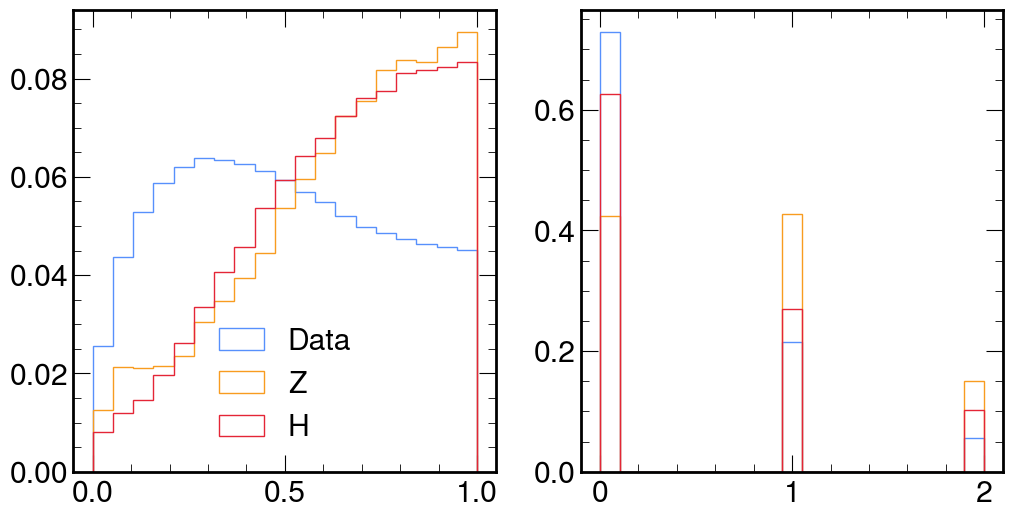

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
bins=np.linspace(0, 1, 20)
cData    = np.histogram(dfs[0].dijet_cs_abs[(dfs[0].PNN>0.4) & dfs[0].jet1_btagDeepFlavB>0.6], bins=bins)[0]
cZ = np.histogram(dfZ.dijet_cs_abs[(dfZ.PNN>0.4) & dfZ.jet1_btagDeepFlavB>0.6], bins=bins, weights=dfZ.weight[(dfZ.PNN>0.4) & dfZ.jet1_btagDeepFlavB>0.6])[0]
cH = np.histogram(dfs[1].dijet_cs_abs[(dfs[1].PNN>0.4) & dfs[1].jet1_btagDeepFlavB>0.6], bins=bins, weights=dfs[1].weight[(dfs[1].PNN>0.4) & dfs[1].jet1_btagDeepFlavB>0.6])[0]
cZ = cZ/np.sum(cZ)
cData = cData/np.sum(cData)
cH = cH/np.sum(cH)
ax[0].hist(bins[:-1], bins=bins, weights=cData, histtype='step', label='Data')
ax[0].hist(bins[:-1], bins=bins, weights=cZ, histtype='step', label='Z')
ax[0].hist(bins[:-1], bins=bins, weights=cH, histtype='step', label='H')
print(cZ/np.sqrt(cData))

bins=np.linspace(0, 2, 20)
cData    = np.histogram(np.clip(dfs[0].nJets_pt30_btag0p2[(dfs[0].PNN>0.4) & dfs[0].jet1_btagDeepFlavB>0.6], bins[0], bins[-1]), bins=bins)[0]
cZ = np.histogram(np.clip(dfZ.nJets_pt30_btag0p2[(dfZ.PNN>0.4) & dfZ.jet1_btagDeepFlavB>0.6], bins[0], bins[-1]), bins=bins, weights=dfZ.weight[(dfZ.PNN>0.4) & dfZ.jet1_btagDeepFlavB>0.6])[0]
cH = np.histogram(np.clip(dfs[1].nJets_pt30_btag0p2[(dfs[1].PNN>0.4) & dfs[1].jet1_btagDeepFlavB>0.6], bins[0], bins[-1]), bins=bins, weights=dfs[1].weight[(dfs[1].PNN>0.4) & dfs[1].jet1_btagDeepFlavB>0.6])[0]
cZ = cZ/np.sum(cZ)
cData = cData/np.sum(cData)
cH = cH/np.sum(cH)
ax[1].hist(bins[:-1], bins=bins, weights=cData, histtype='step', label='Data')
ax[1].hist(bins[:-1], bins=bins, weights=cZ, histtype='step', label='Z')
ax[1].hist(bins[:-1], bins=bins, weights=cH, histtype='step', label='H')
print(cZ/np.sqrt(cData))
ax[0].legend()